In [140]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [141]:
class CustomGaussianMixture(GaussianMixture):
    def __init__(self, n_components=1, covariance_type='full', **kwargs):
        # Handle custom covariance type
        if covariance_type == 'tied_diag':
            # Set to 'tied' for internal validation, use 'tied_diag' as a custom type
            super_covariance_type = 'tied'
            self.custom_covariance_type = 'tied_diag'
        elif covariance_type in ['tied', 'full', 'diag', 'spherical']:
            # Use standard covariance types directly
            super_covariance_type = covariance_type
            self.custom_covariance_type = covariance_type
        else:
            raise ValueError(f"Invalid value for 'covariance_type': {covariance_type}")
        
        # Initialize the base class with a valid covariance type
        super().__init__(n_components=n_components, covariance_type=super_covariance_type, **kwargs)

    def _estimate_covariances(self, resp, X, nk, means):
        if self.custom_covariance_type == 'tied_diag':
            # Calculate the shared diagonal covariance matrix
            avg_X2 = np.dot(resp.T, X ** 2) / nk[:, np.newaxis]
            avg_means2 = means ** 2
            diagonal_covariances = avg_X2 - avg_means2
            # Take the mean across all components to get a single shared diagonal matrix
            self.covariances_ = np.diag(np.mean(diagonal_covariances, axis=0))
            
            # Set the same precision matrix for all components
            self.precisions_cholesky_ = [np.linalg.inv(np.sqrt(self.covariances_))] * self.n_components
        else:
            # For other covariance types, use the standard method
            super()._estimate_covariances(resp, X, nk, means)

In [142]:
# Clusters dasta
clusters = [
    {"mean": [-6, 8], "cov": [[0.4, 0], [0, 0.4]]},
    {"mean": [-4, 7], "cov": [[1, 2], [2, 5]]},
    {"mean": [8, -6], "cov": [[0.4, 0], [0, 0.4]]},
    {"mean": [4, -10], "cov": [[1, 2], [2, 5]]}
]

# Generate the dta points
data = []
for cluster in clusters:
    points = np.random.multivariate_normal(cluster["mean"], cluster["cov"], 100)
    data.append(points)

# Concatenate all data points
data = np.vstack(data)

In [143]:
# Initialize GMM with tied spherical covariance
gmm = CustomGaussianMixture(n_components=4, covariance_type='tied_diag')

# Fit the GMM to the data
gmm.fit(data)

CustomGaussianMixture(covariance_type='tied', n_components=4)

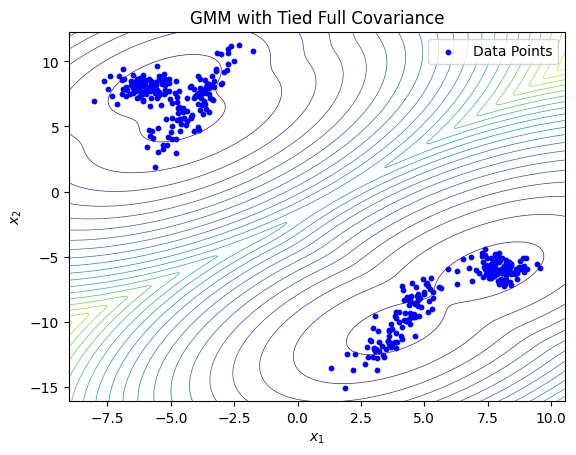

In [ ]:
# Generate a mesh grid to plot the GMM contours
x = np.linspace(data[:, 0].min() - 1, data[:, 0].max() + 1, 200)
y = np.linspace(data[:, 1].min() - 1, data[:, 1].max() + 1, 200)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

# Calculate the GMM's density for each point on the grid
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

# Plot the data points
plt.scatter(data[:, 0], data[:, 1], s=10, color='blue', label="Data Points")
plt.contour(X, Y, Z, levels=20, cmap="viridis", linewidths=0.5)
plt.title("GMM with Tied Diagonal Covariance")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()